# Salesforce Deal Analysis and Prediction

## 1. Objective
The primary goal of this analysis is to **predict the probability of winning current open deals** in the sales pipeline for the upcoming month. By analyzing historical deal data, we aim to:
- Identify the key factors (stage, region, client type) that influence deal success.
- Train a machine learning model to estimate the 'Win Probability' for every active deal.
- Prioritize the sales team's efforts by highlighting high-value, high-probability opportunities expected to close soon.

## 2. Data Sources
We use data exported from Salesforce, specifically the workbook: `Comm Rptg _ ERM Opportunity Data for GC _ 01.29.2026.xlsb`. 
To ensure a robust model, we combine data from two tabs:
1.  **LTM_Opportunity_Data**: Recent opportunities from the Last Twelve Months. This reflects the most current market conditions and sales process.
2.  **L5Yrs_Opportunity_Data**: Historical opportunities from the Last 5 Years. This provides a larger volume of data to train a more statistically significant model.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Set configuration for clearer output
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

### 2.1 Data Loading and Merging
We load both sheets and merge them. Crucially, we remove duplicates based on the Deal `Id`. This is necessary because the LTM (Last 12 Month) data is likely a subset of the 5-Year data. Without de-duplication, recent deals would be over-represented, potentially biasing the model.

In [33]:
# Load Data from Multiple Sheets
file_path = r'raw data/Comm Rptg _ ERM Opportunity Data for GC _ 01.29.2026.xlsb'

try:
    print(f"Reading file: {file_path} ...")
    # Read both sheets using pyxlsb engine for accuracy with binary excel files
    df_ltm = pd.read_excel(file_path, sheet_name='LTM_Opportunity_Data', engine='pyxlsb')
    print(f"Loaded LTM_Opportunity_Data: {df_ltm.shape} records.")
    
    df_5yr = pd.read_excel(file_path, sheet_name='L5Yrs_Opportunity_Data', engine='pyxlsb')
    print(f"Loaded L5Yrs_Opportunity_Data: {df_5yr.shape} records.")
    
    # Combine datasets
    df = pd.concat([df_ltm, df_5yr], ignore_index=True)
    
    # De-duplicate based on 'Id' to ensure each unique deal is counted only once
    if 'Id' in df.columns:
        initial_len = len(df)
        df = df.drop_duplicates(subset=['Id'])
        print(f"Combined shape after dropping ID duplicates: {df.shape} (Removed {initial_len - len(df)} duplicate rows)")
    else:
        print(f"Combined shape (no Id check): {df.shape}")
        
    # Standardize column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()
    
except ValueError as ve:
    print(f"Sheet name error: {ve}. Please check exact sheet names in the Excel file.")
except ImportError:
    print("Error: 'pyxlsb' library is missing. Please run: !pip install pyxlsb")
except Exception as e:
    print(f"Unexpected erro: {e}")

if 'df' in locals():
    display(df.head())

Reading file: raw data/Comm Rptg _ ERM Opportunity Data for GC _ 01.29.2026.xlsb ...
Loaded LTM_Opportunity_Data: (48570, 31) records.
Loaded L5Yrs_Opportunity_Data: (142128, 31) records.
Combined shape after dropping ID duplicates: (142128, 34) (Removed 48570 duplicate rows)


,Id,Project / Title,Stage,Expected Start Date,OwnerId,Created Date,Service,Opportunity Number,Service Group,Country/Entity,Business Unit,Region,Client Type,Sole Source / Competitive,Detail Industry,Core Industry,Un-Wtd Net Amount Converted,Expected Close FY,Expected Close FP,IsClosed,IsWon,Created FP,Last Modified Date,Stage Change Date,Standalone vs. CO,Critical_Minerals__c,CM_Text,Ultimate_Parent_Client,SF Close FP,Ultimate Client Name,Sales POD,R2L Priority,Is_Work_for_an_Ultimate_Client__c,Ultimate_Client__c
0,006Vn00000Qve09IAB,ISO/OHSAS Pre Assessment Audit,7. Abandoned,46010,00560000001WF31AAG,45972,Management Systems & Compliance,806661,Sustainable Operations,Eastern Canada,Canada,North America,Client,Competitive,Utilities,Power,32374,Overdue,202609.0,True,False,202608.0,45987,45986.0,Standalone,False,No,Elexicon Energy Inc.,202608.0,NaN,NaN,NaN,NaN,NaN
1,006Vn00000QbhQQIAZ,IT Strategy & Policy Support,7. Abandoned,46022,0057V000008YyTJQA0,45965,Digital Systems Implementation,805825,Sustainable Operations,Eastern Canada,Canada,North America,Client,Competitive,Government,Government,4,Overdue,202609.0,True,False,202608.0,46010,46010.0,Standalone,False,No,Qikiqtani Inuit Association,202609.0,NaN,NaN,NaN,NaN,NaN
2,006Vn00000Qap1rIAB,On Call Air Support,7. Abandoned,46038,0057V00000ADU8WQAX,45965,Air Quality,805800,Sustainable Operations,Great Lakes West,Great Lakes & Northeast,North America,Client,Sole Source,Manufacturing,Manufacturing,50000,Overdue,202610.0,True,False,202608.0,45974,45974.0,Standalone,False,No,"Southwire Company, LLC",202608.0,NaN,NaN,NaN,NaN,NaN
3,006Vn00000Q4bbWIAR,Report design and storytelling,7. Abandoned,45989,005Vn000000RB7cIAG,45954,Sustainability Marcomms Agency,804052,Corporate Sustainability & Climate Change,Shelton Group,Climate Sustainability & Transactions,North America,Client,Competitive,Forestry/Pulp/Paper,Manufacturing,50000,Overdue,202608.0,True,False,202607.0,45954,45953.0,Standalone,False,No,Deli Home,202607.0,NaN,NaN,NaN,NaN,NaN
4,006Vn00000Po8teIAB,Axalta Coating Systems - Mt. Clemens GACO Tech...,7. Abandoned,45971,00560000001WF3YAAW,45950,Site Investigation,803420,Liability Portfolio Management & Remediation,Great Lakes East,Great Lakes & Northeast,North America,Client,Sole Source,Chemical,Chemical,40000,Overdue,202608.0,True,False,202607.0,45979,45979.0,Change Order,False,No,Axalta Coating Systems,202608.0,NaN,NaN,NaN,NaN,NaN


## 3. Data Preprocessing
Raw sales data often contains messy formats or missing values. In this step, we:
1.  **Map Columns**: Identify the correct columns even if naming varies slightly.
2.  **Convert Data Types**: Ensure dates are real DateTime objects and Amounts are numbers (handling any currency symbols or text).
3.  **Define Target Variable (`IsWon`)**: The model needs a clear 1 (Won) vs 0 (Lost) target. We derive this from the `IsWon` boolean flag or infer it from the `Stage` (e.g., "Closed Won").
4.  **Split History vs. Active**: We separate "Closed" deals (for training) from "Open" deals (for prediction).

In [34]:
# Preprocessing & Mapping
if 'df' in locals():
    # Helper to find column case-insensitively
    def get_col(df, name):
        for c in df.columns:
            if c.lower() == name.lower(): return c
        return None

    # Flexible Column Mapping
    col_mapping = {
        'Created Date': get_col(df, 'Created Date'),
        'Expected Start Date': get_col(df, 'Expected Start Date'),
        'Expected Close FP': get_col(df, 'Expected Close FP'),
        'Amount': get_col(df, 'Un-Wtd Net Amount Converted') or get_col(df, 'Amount'), 
        'IsWon': get_col(df, 'IsWon'),
        'IsClosed': get_col(df, 'IsClosed'),
        'Stage': get_col(df, 'Stage'),
        'Sales POD': get_col(df, 'Sales POD'),
        'Region': get_col(df, 'Region')
    }
    
    print("Column Mapping used:", col_mapping)

    # 1. Date Conversion: Essential for time-based filtering
    for col in [col_mapping['Created Date'], col_mapping['Expected Start Date']]:
        if col: df[col] = pd.to_datetime(df[col], errors='coerce')

    # 2. Amount Cleaning: Convert to numeric, treating errors as 0
    if col_mapping['Amount']:
        df['Amount'] = pd.to_numeric(df[col_mapping['Amount']], errors='coerce').fillna(0)
    else:
        df['Amount'] = 0

    # 3. Create Target Variable (IsWon_Target)
    # This is what the model tries to predict: 1 = Deal Won, 0 = Deal Lost
    if col_mapping['IsWon']:
        df['IsWon_Target'] = df[col_mapping['IsWon']].astype(str).apply(lambda x: 1 if x.lower() in ['1', 'true', 'yes', 'won'] else 0)
    elif col_mapping['Stage']:
        # Fallback: Inference from Stage name
        df['IsWon_Target'] = df[col_mapping['Stage']].apply(lambda x: 1 if str(x).lower() == 'closed won' else 0)

    # 4. Define Historical (Training) vs Active (Prediction) Data
    if col_mapping['IsClosed']:
        df['IsClosed_Bool'] = df[col_mapping['IsClosed']].astype(str).apply(lambda x: True if x.lower() in ['true', '1', 'yes'] else False)
    elif col_mapping['Stage']:
        closed_stages = ['Closed Won', 'Closed Lost', 'Omitted', 'Declined', 'Duplicate']
        df['IsClosed_Bool'] = df[col_mapping['Stage']].isin(closed_stages)
    else:
         df['IsClosed_Bool'] = True # Default to all closed if unsure
            
    # Quick Check on Data Volume
    print(f"Total Deals: {len(df)}")
    print(f"Overall Win Rate (Historical): {df[df['IsClosed_Bool']]['IsWon_Target'].mean():.2%}")

Column Mapping used: {'Created Date': 'Created Date', 'Expected Start Date': 'Expected Start Date', 'Expected Close FP': 'Expected Close FP', 'Amount': 'Un-Wtd Net Amount Converted', 'IsWon': 'IsWon', 'IsClosed': 'IsClosed', 'Stage': 'Stage', 'Sales POD': 'Sales POD', 'Region': 'Region'}
Total Deals: 142128
Overall Win Rate (Historical): 54.39%


## 4. Modeling (Random Forest)
We use a **Random Forest Classifier**. This algorithm is chosen because:
- It handles a mix of numerical frequencies (Amount) and categorical data (Region, Stage) very well.
- It is less prone to overfitting than a single Decision Tree.
- It provides "probabilities" out of the box, not just a yes/no prediction.

**Features Used:**
- `Stage`: The current progress of the deal (highly predictive).
- `Region` & `Sales POD`: Geographic or team-based factors.
- `Client Type`: The nature of the customer.
- `Business Unit`: The internal unit handling the deal.
- `Amount`: The size of the deal.

Features selected for training: ['Stage', 'Region', 'Sales POD', 'Client Type', 'Business Unit', 'Amount']

Model successfully trained on historical data.


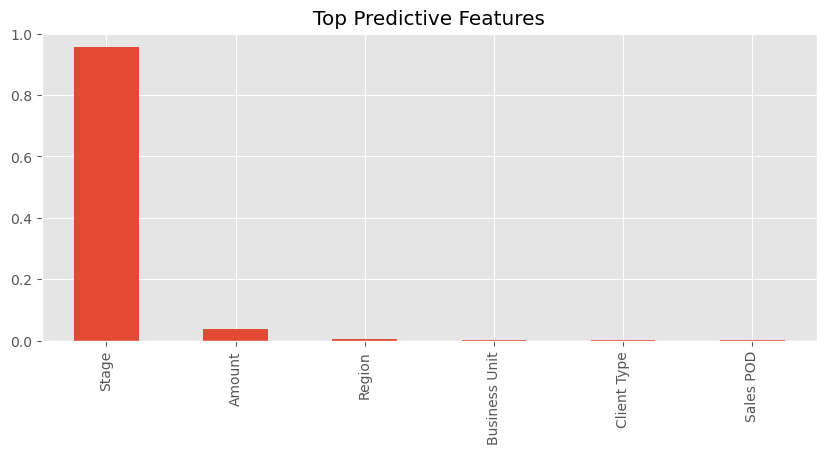

In [35]:
if 'df' in locals():
    # Select Features
    feats = ['Stage', 'Region', 'Sales POD', 'Client Type', 'Business Unit', 'Amount']
    
    # Only use features that actually exist in the file
    valid_feats = [f for f in feats if (f == 'Amount' or get_col(df, f))]
    selected_cols = []
    for f in valid_feats:
        if f == 'Amount': selected_cols.append('Amount')
        else: selected_cols.append(get_col(df, f))
    
    print(f"Features selected for training: {selected_cols}")

    # Split Data
    historical_df = df[df['IsClosed_Bool'] == True].copy()
    active_df = df[df['IsClosed_Bool'] == False].copy()
    
    if not historical_df.empty:
        X = historical_df[selected_cols].copy()
        y = historical_df['IsWon_Target']
        
        # Handle Missing Values (Imputation)
        for c in selected_cols:
            if X[c].dtype == 'object': X[c] = X[c].fillna('Unknown')
            else: X[c] = X[c].fillna(0)
                
        # Feature Encoding (Convert text to numbers)
        encoders = {}
        for c in X.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            # We fit on ALL data (Closed + Open) to ensure we know all categories
            combined = pd.concat([df[c].astype(str), pd.Series(['Unknown'])], axis=0)
            le.fit(combined)
            encoders[c] = le
            X[c] = le.transform(X[c].astype(str))
            
        # Train the Model
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        print("\nModel successfully trained on historical data.")
        
        # Optional: Check accuracy on training set (or a split) to sanity check
        # Here we just print feature importance
        importances = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        plt.figure(figsize=(10,4))
        importances.plot(kind='bar')
        plt.title("Top Predictive Features")
        plt.show()

## 5. Forecasting Next Month's Deals
Now we apply the trained model to the **Active (Open)** deals.
1.  **Score Deals**: Calculate the `Win_Probability` for each open deal.
2.  **Calculate Expected Value**: `Amount` * `Win_Probability`. This gives a risk-adjusted view of the pipeline.
3.  **Filter Timeframe**: We look for deals with an `Expected Close FP` (Fiscal Period) falling in the next month (e.g., 2026-02 to 2026-03).
4.  **Rank**: Sort deals by Expected Value to show where the team should focus.

In [36]:
if 'active_df' in locals() and not active_df.empty:
    print("Preparing predictions for active deals...")
    
    # Check if selected_cols exists (from Step 4)
    if 'selected_cols' not in locals():
        # Re-define if missing
        feats = ['Stage', 'Region', 'Sales POD', 'Client Type', 'Business Unit', 'Amount']
        valid_feats = [f for f in feats if (f == 'Amount' or get_col(df, f))]
        selected_cols = []
        for f in valid_feats:
            if f == 'Amount': selected_cols.append('Amount')
            else: selected_cols.append(get_col(df, f))
    
    # Check if encoders exists
    if 'encoders' not in locals():
        print("Error: 'encoders' not found. Please run the Model Training step first.")
    elif 'rf' not in locals():
        print("Error: 'rf' (Model) not found. Please run the Model Training step first.")
    else:
        # Prepare Active Data
        X_act = active_df[selected_cols].copy()
        
        # Handle Missing Values
        for c in selected_cols:
            if X_act[c].dtype == 'object': 
                X_act[c] = X_act[c].fillna('Unknown')
            else: 
                X_act[c] = X_act[c].fillna(0)
        
        # Safe Encoding
        for c in X_act.select_dtypes(include=['object']).columns:
            if c in encoders:
                le = encoders[c]
                # Safe Transform: Map unseen labels to 'Unknown'
                # Ensure 'Unknown' is in classes (it was added in Step 4)
                valid_classes = set(le.classes_)
                
                # Use apply to replace invalid labels
                X_act[c] = X_act[c].astype(str).apply(lambda x: x if x in valid_classes else 'Unknown')
                
                # Transform
                X_act[c] = le.transform(X_act[c])
        
        # Predict
        try:
            active_df['Win_Probability'] = rf.predict_proba(X_act)[:, 1]
            active_df['Expected_Revenue'] = active_df['Amount'] * active_df['Win_Probability']
            print("Predictions generated.")
            
            # --- FILTER FOR NEXT MONTH ---
            fp_col = col_mapping.get('Expected Close FP')
            # Fallback to date if FP missing
            date_col = col_mapping.get('Expected Start Date')
            
            next_month_deals = pd.DataFrame()
            
            if fp_col:
                # Numeric FP Check
                active_df['FP_Num'] = pd.to_numeric(active_df[fp_col], errors='coerce')
                target_start, target_end = 202602, 202603
                next_month_deals = active_df[active_df['FP_Num'].between(target_start, target_end)].copy()
            elif date_col:
                # Date Check (February 2026)
                next_month_deals = active_df[
                    (active_df[date_col].dt.year == 2026) & 
                    (active_df[date_col].dt.month.isin([2, 3]))
                ].copy()
                
            if not next_month_deals.empty:
                print(f"\n--- PREDICTION RESULTS ({len(next_month_deals)} deals found) ---")
                
                # Display Config
                disp_cols = ['Project', 'Stage', 'Amount', 'Win_Probability', 'Expected_Revenue']
                final_disp = []
                
                # Map vars for display
                if get_col(df, 'Project / Title'): 
                    next_month_deals['Project'] = next_month_deals[get_col(df, 'Project / Title')]
                    final_disp.append('Project')
                
                stage_c = get_col(df, 'Stage')
                if stage_c: 
                    next_month_deals['Stage'] = next_month_deals[stage_c]
                    final_disp.append('Stage')
                    
                final_disp.extend(['Amount', 'Win_Probability', 'Expected_Revenue'])
                
                # Sort and Show
                top_deals = next_month_deals.sort_values(by='Expected_Revenue', ascending=False).head(15)
                
                # Styling
                try:
                    display(top_deals[final_disp].style.format({
                        'Amount': '${:,.0f}',
                        'Expected_Revenue': '${:,.0f}',
                        'Win_Probability': '{:.1%}'
                    }))
                except:
                    # Fallback if style fails
                    display(top_deals[final_disp])
            else:
                print("No deals found closing in the next month window (202602-202603). showing top active deals instead.")
                display(active_df.sort_values(by='Expected_Revenue', ascending=False).head(10))
                
        except Exception as e:
            print(f"Error during prediction calculation: {e}")

Preparing predictions for active deals...
Predictions generated.

--- PREDICTION RESULTS (16 deals found) ---


,Project,Stage,Amount,Win_Probability,Expected_Revenue
4578,JLL-US- Tech Vertical Support,1. Identify Opp,"$250,000",100.0%,"$250,000"
5896,JLL-Qualtrics-HS Support,1. Identify Opp,"$200,000",100.0%,"$200,000"
126130,BHP - BMA - Blackwater Nature+Carbon Valuation Study,2. Qualify Opp,"$66,225",100.0%,"$66,225"
19668,IDB Invest - Biodiversity Offsets,4. Issue Proposal,"$65,000",100.0%,"$65,000"
130101,Real Estate Decarbonisation pilot,2. Qualify Opp,"$64,935",100.0%,"$64,935"
130980,ABN AMRO-NL-CSCC-Human rights strategy support,1. Identify Opp,"$54,348",99.0%,"$53,805"
19893,Woodside HSE Australia 2025 Cut-over Support,3. Develop Proposal,"$46,358",100.0%,"$46,358"
4584,Sustainable Procurement,1. Identify Opp,"$45,000",100.0%,"$45,000"
145358,PLANO CONCEITUAL EHS BARRA MANSA,4. Issue Proposal,"$38,128",100.0%,"$38,128"
118233,Orica - ANZ - Book & Claim system for Am Nit,1. Identify Opp,"$33,113",100.0%,"$33,113"
